In [1]:
# Get all the modules into our path.
import sys
sys.path.insert(0,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos')
sys.path.insert(1,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github')

# Import machine learning modules.
from omphalos import file_methods as fm
from omphalos import attributes as attr
from omphalos import labels as lbls
import analysis as ana
from analysis import helper as hp

# Import data processing modules.
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl

# Import some extra modules
import re

# Import data visualisation modules.
import matplotlib.pyplot as plt

In [2]:
# Port in and unpack all the runs we need from the .pkl file.
TrainSet_cl_dict_1 = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bcm/2022-05-31_bcm_4-1/basalt_cl-.in')
TrainSet_cl_dict_2 = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/easter/mres/CrunchFlow_Work/bcm/2022-05-31_bcm_4-1/basalt_cl-_2.pkl')

In [3]:
# Merging the two dictionaries
TrainSet_cl_1_len = len(TrainSet_cl_dict_1.keys())
TrainSet_cl_2_len = len(TrainSet_cl_dict_2.keys())
# Creating an array of all the keys in second dict
TrainSet_cl_2_OldKeys_arr = []
for key in TrainSet_cl_dict_2.keys():
    TrainSet_cl_2_OldKeys_arr.append(key)
# Creating an array of all the new key numbers needed
TrainSet_cl_2_NewKeys_arr = [x + TrainSet_cl_1_len for x in TrainSet_cl_2_OldKeys_arr]
# Creating a new dictionary of old keys : new keys
TrainSet_cl_2_OldNewKeys_dict = dict(zip(TrainSet_cl_2_OldKeys_arr, TrainSet_cl_2_NewKeys_arr))
# Updating the keys in the second dictionary using the new dictionary of old keys : new keys
TrainSet_cl_dict_2 = dict([(TrainSet_cl_2_OldNewKeys_dict.get(key), value) for key, value in TrainSet_cl_dict_2.items()])
# Merge the two different dictionaries with their newly continuous sets of keys
TrainSet_cl_dict = TrainSet_cl_dict_1 | TrainSet_cl_dict_2

In [4]:
# Filter all errored files out of the dictionary
dataset_dict, error_dict = hp.filter_errors(TrainSet_cl_dict)

Returned 14893 files without errors out of a total possible 14970.
77 files had errors.
0 files had unhandled errors.
File failure rate: 0.5170214194588061 %.
To see unhandled errors, run with verbose=True.


In [5]:
# Get a df of all the start attributes of interest
attributes_all_df = attr.get_condition(dataset_dict,"basalt",species_concs=True)
attributes_all_df = attributes_all_df.loc[:, ['Ca++', 'Fe++', 'Mg++']]
attributes_all_df

/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)


,Ca++,Fe++,Mg++
0,0.000017,0.000253,0.000103
1,0.000135,0.000168,0.000169
2,0.000069,0.000119,0.000051
3,0.000079,0.000218,0.000222
4,0.000236,0.000180,0.000211
...,...,...,...
14888,0.000037,0.000194,0.000083
14889,0.000235,0.000131,0.000090
14890,0.000262,0.000144,0.000178
14891,0.000242,0.000246,0.000028


In [6]:
def NrFormatFixer_XYZTime(xr_DataSet):
    for _ in xr_DataSet.X.values:
        for __ in xr_DataSet.Y.values:
            for ___ in xr_DataSet.Z.values:
                for ____ in xr_DataSet.time.values:
                    for _____ in xr_DataSet.data_vars:
                        xr_DataArray = xr_DataSet[f'{_____}'].loc[dict(X=f'{_}',Y=f'{__}',Z=f'{___}',time=f'{____}')]
                        for ______ in range(0,len(xr_DataArray)):
                            string = str(xr_DataArray.values[______])
                            new_val = string
                            if re.match("^\d+\.\d+-\d+$",string):
                                i_rev = 1
                                str_len = len(string)
                                for _______ in reversed(string):
                                    if _______ == "-":
                                        break
                                    else:
                                        i_rev+=1
                                        continue
                                i = str_len - i_rev
                                new_string = string[:i] + "e" + string[i:]
                                new_val = new_string
                            xr_DataArray.values[______] = new_val
    return xr_DataSet

In [7]:
def NrFormatFixer_XYZ(xr_DataSet):
    for _ in xr_DataSet.X.values:
        for __ in xr_DataSet.Y.values:
            for ___ in xr_DataSet.Z.values:
                for _____ in xr_DataSet.data_vars:
                    xr_DataArray = xr_DataSet[f'{_____}'].loc[dict(X=f'{_}',Y=f'{__}',Z=f'{___}')]
                    for ______ in range(0,len(xr_DataArray)):
                        string = str(xr_DataArray.values[______])
                        new_val = string
                        if re.match("^\d+\.\d+-\d+$",string):
                            i_rev = 1
                            str_len = len(string)
                            for _______ in reversed(string):
                                if _______ == "-":
                                    break
                                else:
                                    i_rev+=1
                                    continue
                            i = str_len - i_rev
                            new_string = string[:i] + "e" + string[i:]
                            new_val = new_string
                        xr_DataArray.values[______] = new_val
    return xr_DataSet

In [24]:
# Retrieval of xarray datasets containing final and initial mineralogical volume fractions
FinalVols_ds = lbls.raw(dataset_dict, 'volume')
FinalVols_ds = NrFormatFixer_XYZTime(FinalVols_ds)
FinalVols_ds = FinalVols_ds.astype(float)

InitialVols_ds = attr.initial_conditions(dataset_dict, concentrations=False, minerals=True)
InitialVols_ds = NrFormatFixer_XYZ(InitialVols_ds)
InitialVols_ds = InitialVols_ds.astype(float)

# Generation of an xarray dataset representing change in mineralogical volume fractions
DeltVolFrac_ds = FinalVols_ds - InitialVols_ds

# Generation of an narrowed-down xarray dataset containing only data on a specific time and place
DeltVolFrac_TenYr_ds = DeltVolFrac_ds.sel(X=0.5,Y=0.5,Z=0.5,time=0.1)

# Generation of an additional xarray variable entitled Carbonates; placed into the above xarray dataset
DeltVolFrac_TenYr_ds = DeltVolFrac_TenYr_ds.assign(Carbonates=lambda DeltVolFrac_TenYr_ds: DeltVolFrac_TenYr_ds.Calcite + DeltVolFrac_TenYr_ds.Siderite + DeltVolFrac_TenYr_ds.Magnesite)

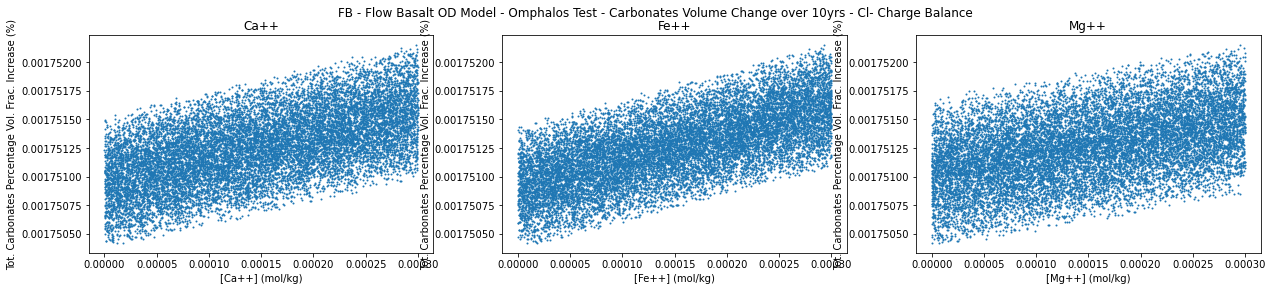

In [25]:
fig, ((ax1),(ax2),(ax3)) = plt.subplots(1,3)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Carbonates Volume Change over 10yrs - Cl- Charge Balance')

fig.set_figheight(4)
fig.set_figwidth(21)

ax1.set_title("Ca++", loc='center')
ax2.set_title("Fe++", loc='center')
ax3.set_title("Mg++", loc='center')

ax1.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')

ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')

ax1_x = attributes_all_df["Ca++"].values
ax1_y = DeltVolFrac_TenYr_ds.Carbonates.values

ax2_x = attributes_all_df["Fe++"].values
ax2_y = DeltVolFrac_TenYr_ds.Carbonates.values

ax3_x = attributes_all_df["Mg++"].values
ax3_y = DeltVolFrac_TenYr_ds.Carbonates.values

ax1.scatter(x=ax1_x, y=ax1_y, s=1, alpha=1)
ax2.scatter(x=ax2_x, y=ax2_y, s=1, alpha=1)
ax3.scatter(x=ax3_x, y=ax3_y, s=1, alpha=1)

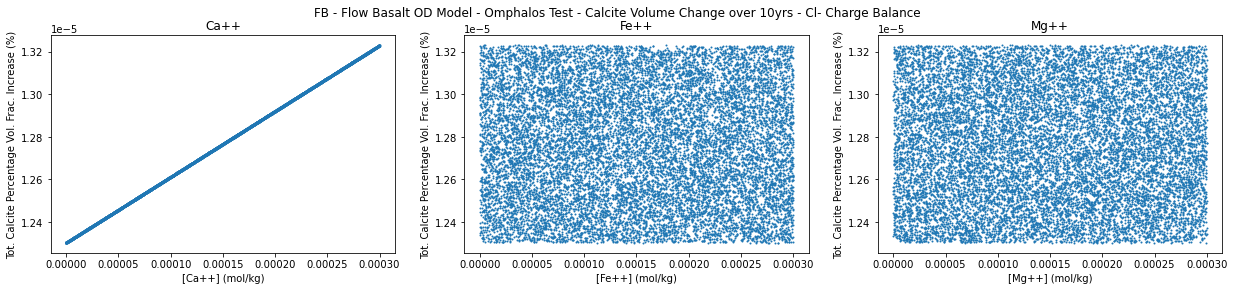

In [26]:
fig, ((ax1),(ax2),(ax3)) = plt.subplots(1,3)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Calcite Volume Change over 10yrs - Cl- Charge Balance')

fig.set_figheight(4)
fig.set_figwidth(21)

ax1.set_title("Ca++", loc='center')
ax2.set_title("Fe++", loc='center')
ax3.set_title("Mg++", loc='center')

ax1.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')

ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')

ax1_x = attributes_all_df["Ca++"].values
ax1_y = DeltVolFrac_TenYr_ds.Calcite.values

ax2_x = attributes_all_df["Fe++"].values
ax2_y = DeltVolFrac_TenYr_ds.Calcite.values

ax3_x = attributes_all_df["Mg++"].values
ax3_y = DeltVolFrac_TenYr_ds.Calcite.values

ax1.scatter(x=ax1_x, y=ax1_y, s=1, alpha=1)
ax2.scatter(x=ax2_x, y=ax2_y, s=1, alpha=1)
ax3.scatter(x=ax3_x, y=ax3_y, s=1, alpha=1)

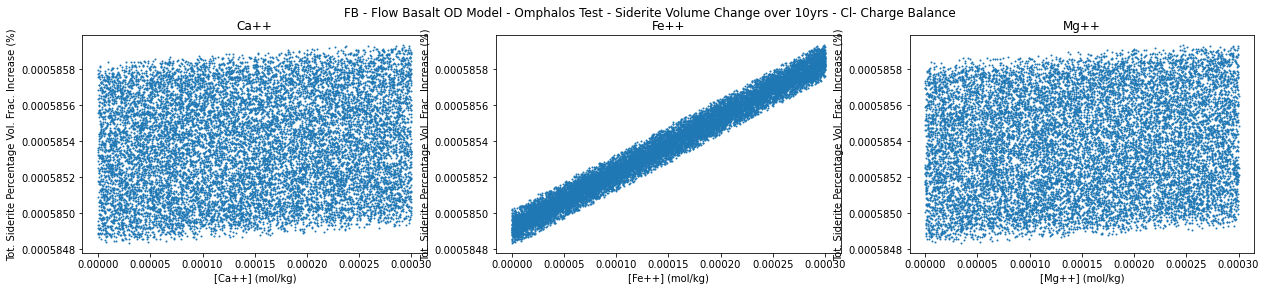

In [27]:
fig, ((ax1),(ax2),(ax3)) = plt.subplots(1,3)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Siderite Volume Change over 10yrs - Cl- Charge Balance')

fig.set_figheight(4)
fig.set_figwidth(21)

ax1.set_title("Ca++", loc='center')
ax2.set_title("Fe++", loc='center')
ax3.set_title("Mg++", loc='center')

ax1.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')

ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')

ax1_x = attributes_all_df["Ca++"].values
ax1_y = DeltVolFrac_TenYr_ds.Siderite.values

ax2_x = attributes_all_df["Fe++"].values
ax2_y = DeltVolFrac_TenYr_ds.Siderite.values

ax3_x = attributes_all_df["Mg++"].values
ax3_y = DeltVolFrac_TenYr_ds.Siderite.values

ax1.scatter(x=ax1_x, y=ax1_y, s=1, alpha=1)
ax2.scatter(x=ax2_x, y=ax2_y, s=1, alpha=1)
ax3.scatter(x=ax3_x, y=ax3_y, s=1, alpha=1)

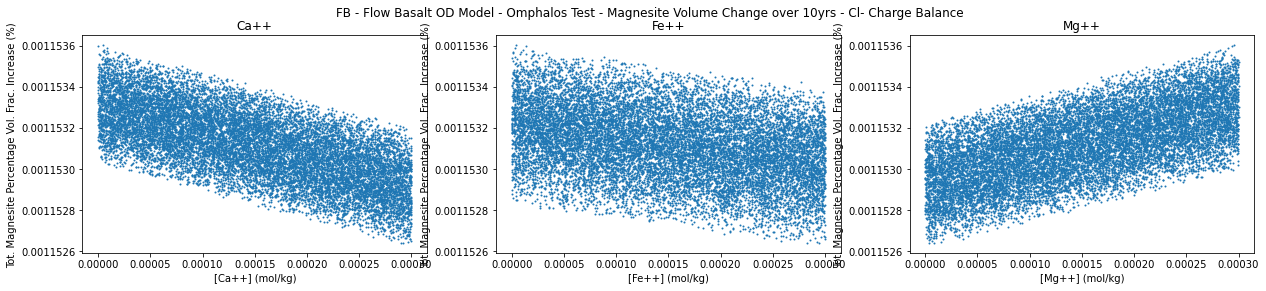

In [28]:
fig, ((ax1),(ax2),(ax3)) = plt.subplots(1,3)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Magnesite Volume Change over 10yrs - Cl- Charge Balance')

fig.set_figheight(4)
fig.set_figwidth(21)

ax1.set_title("Ca++", loc='center')
ax2.set_title("Fe++", loc='center')
ax3.set_title("Mg++", loc='center')

ax1.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')

ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')

ax1_x = attributes_all_df["Ca++"].values
ax1_y = DeltVolFrac_TenYr_ds.Magnesite.values

ax2_x = attributes_all_df["Fe++"].values
ax2_y = DeltVolFrac_TenYr_ds.Magnesite.values

ax3_x = attributes_all_df["Mg++"].values
ax3_y = DeltVolFrac_TenYr_ds.Magnesite.values

ax1.scatter(x=ax1_x, y=ax1_y, s=1, alpha=1)
ax2.scatter(x=ax2_x, y=ax2_y, s=1, alpha=1)
ax3.scatter(x=ax3_x, y=ax3_y, s=1, alpha=1)